# Plot the data as in the Sculptor paper

In [1]:
#Import the standard modules
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits 
from astropy.io import ascii 
from astropy.table import Table, vstack, hstack, join
import math
from math import pi,cos,sin,tan,atan

In [2]:
def tangent( raref, decref, ra, dec ):
    #Converts ra, dec to tangent plane coordinates.
    #Input/output in degrees

    cotdec=1./(np.tan(np.radians(dec)))
    denom=(np.sin(np.radians(decref))
           + cotdec
           *np.cos(np.radians(decref)) 
           *np.cos(np.radians(ra-raref))
          )
    eta_num=np.cos(np.radians(decref))-(
        cotdec*np.sin(np.radians(decref))*np.cos(np.radians(ra-raref))
    )
    xki_num=cotdec*np.sin(np.radians(ra-raref))

    xki=np.degrees(xki_num/denom)
    eta=np.degrees(eta_num/denom)

    return xki,eta

In [8]:
def ellipse_rad(x, y, a, b, PA):
    """
    Calculate the elliptical radius for a set of x, y coordinates.
    
    Parameters:
    x : ndarray
        x-coordinates of the points.
    y : ndarray
        y-coordinates of the points.
    a : float
        Semi-major axis of the ellipse.
    b : float
        Semi-minor axis of the ellipse.
    PA : float
        Position angle of the ellipse (in radians).
    
    Returns:
    r : ndarray
        The elliptical radius for each set of x, y coordinates.
    """
    
    # Transform x, y into the ellipse's coordinate system
    θ = np.deg2rad(PA)
    x_prime = x * np.cos(θ) + y * np.sin(θ)
    y_prime = -x * np.sin(θ) + y * np.cos(θ)
    
    # Calculate the elliptical radius
    r = np.sqrt((x_prime / a) ** 2 + (y_prime / b) ** 2)
    
    return r

# Density distribution with equally spaced points in logR

In [21]:
#path = 'literature/'

from scipy.optimize import curve_fit
from scipy.special import gamma
from scipy.special import gammainc

def model_f(r_mod,a,b):
  return a*np.exp(-r_mod/b)


def exp_a(r_mod,a):
  return a*np.exp(-r_mod/0.6)

#These are the data from Battaglia+2022, if you don't have it, maybe remove it? Not sure these are public

candid=Table.read('b19.fits', format='fits')

ra_cand=np.array(candid['RA_ICRS']) 
dec_cand=np.array(candid['DE_ICRS'])
prob_cand=np.array(candid['Pmemb'])
#rell_cand=12.33*np.array(candid['r_ell'])

good_prob_ind=np.where( prob_cand>0.1 )
        
ra=ra_cand[good_prob_ind]
dec=dec_cand[good_prob_ind]
prob=prob_cand[good_prob_ind]

#These are from Jaclyn
candid_j=Table.read('../Sculptor.GAIASOURCE.RUWE.VELS.PROB.fits', format='fits')

xi_cand_j=np.array(candid_j['xi']) 
eta_cand_j=np.array(candid_j['eta'])
rell_cand_j=np.array(candid_j['r_ell'])

#change the centre of your system
raref=15.039166666666665 
decref=-33.70916666666667

#to go in the projected coordinates
xi,eta=tangent(raref,decref,ra,dec)

#change these according to your system
ecc=0.37 #1-b/a
a=12.33/60       #radius on the x-axis
b=(1-ecc)*a      #radius on the y-axis
PA=94

rell_cand = np.sqrt( ellipse_rad(xi, eta, a, b,  90 - PA, ) )
print(max(rell_cand),'max r_ell candidates')


#Penarrubia2008 model after the first apocentric passage
pena=Table.read('first_apo.csv', format='ascii', delimiter=',')
pox=np.array(pena['x']) 
poy_ex=np.array(pena['y'])

#change the 5.8 to your system
poy=np.power(10,poy_ex)
por=np.power(10,pox)*5.8  #in arcmin

#Penarrubia2008 model without tides 
pena2=Table.read( 'no_tides.csv', format='ascii', delimiter=',')
pox2=np.array(pena2['x']) 
poy_ex2=np.array(pena2['y'])

#change the 5.8 to your system, it is the core radius
poy2=np.power(10,poy_ex2)
por2=np.power(10,pox2)*5.8  #in arcmin

#core radius 5.8 \pm 1.6 arcmin
fs1=20
nbins=30
bins=np.logspace(start=np.log10(0.01), stop=np.log10(13.1), num=nbins)

#counts, bins = np.histogram(rell_cand,bins=nbins)
x_bin=np.zeros(nbins-1)
dx_bin=np.zeros(nbins-1)
for i in range(nbins-1):
    
    x_bin[i]=(bins[i+1]+bins[i])/2.0
    dx_bin[i]=(bins[i+1]-bins[i])/2.0
    #print(x_bin[i],i,x_bin[i+1],bins[20])
    


#area_bin=np.zeros(nbins)
#darea_bin=np.zeros(nbins)
surf_dens=np.zeros(nbins-1)
surf_dens_err=np.zeros(nbins-1)
nstars=np.zeros(nbins-1)
#np.pi*a*b


#change the half light radius, here is 12.33 arcmin
for i in range(nbins-1):

    area_big=np.pi*bins[i+1]*(1-ecc)*bins[i+1]
    area_small=np.pi*bins[i]*(1-ecc)*bins[i]
    area_diff=area_big-area_small  #area in unit of r_h^2 or arcmin^2
    if i==0:
        nstars_ind=np.where( (rell_cand<=bins[i+1]) & (rell_cand>=bins[i]) )
    else:
        nstars_ind=np.where( (rell_cand<=bins[i+1]) & (rell_cand>bins[i]) )
        
    nstars_ind_n=np.asarray(nstars_ind)
    nstars[i]=float(len(nstars_ind_n[0]))
    #print(nstars_ind_n)
    #print( np.float(len(nstars_ind_n[0])) )
    
    #surf_dens[i]= nstars[i]/(area_diff) #in number of stars/arcmin^2
    #surf_dens_err[i]= np.sqrt(nstars[i])/(area_diff)
    surf_dens[i]= nstars[i]/(area_diff*12.33*12.33) #in number of stars/arcmin^2
    surf_dens_err[i]= np.sqrt(nstars[i])/(area_diff*12.33*12.33)
    
x_bin_j=np.zeros(nbins-1)
dx_bin_j=np.zeros(nbins-1)
for i in range(nbins-1):
    
    x_bin_j[i]=(bins[i+1]+bins[i])/2.0
    dx_bin_j[i]=(bins[i+1]-bins[i])/2.0
    #print(x_bin[i],i,x_bin[i+1],bins[20])
    


#area_bin=np.zeros(nbins)
#darea_bin=np.zeros(nbins)
surf_dens_j=np.zeros(nbins-1)
surf_dens_err_j=np.zeros(nbins-1)
nstars_j=np.zeros(nbins-1)
#np.pi*a*b

for i in range(nbins-1):

    area_big_j=np.pi*bins[i+1]*(1-ecc)*bins[i+1]
    area_small_j=np.pi*bins[i]*(1-ecc)*bins[i]
    area_diff_j=area_big_j-area_small_j  #area in unit of r_h^2 or arcmin^2
    if i==0:
        nstars_ind_j=np.where( (rell_cand_j<=bins[i+1]) & (rell_cand_j>=bins[i]) )
    else:
        nstars_ind_j=np.where( (rell_cand_j<=bins[i+1]) & (rell_cand_j>bins[i]) )
        
    nstars_ind_n_j=np.asarray(nstars_ind_j)
    nstars_j[i]=float(len(nstars_ind_n_j[0]))
    
    surf_dens_j[i]= nstars_j[i]/(area_diff_j*12.33*12.33) #in number of stars/arcmin^2
    surf_dens_err_j[i]= np.sqrt(nstars_j[i])/(area_diff_j*12.33*12.33)

popt_j, pcov_j = curve_fit(exp_a, x_bin[(x_bin*12.33>1) & (x_bin*12.33<25)], surf_dens_j[(x_bin*12.33>1) & (x_bin*12.33<25)])
a_opt_j= popt_j

a_opt, pcov = curve_fit(exp_a, x_bin[(x_bin*12.33>1) & (x_bin*12.33<25)], surf_dens_j[(x_bin*12.33>1) & (x_bin*12.33<25)])

#x_model = np.linspace(0, 10, 1000) #if in r_h
x_model_j =np.logspace(start=np.log10(0.01), stop=np.log10(20), num=1000)
x_model = np.linspace(0, 150, 10000) #if in arcmin
y_model_j = exp_a(x_model_j, a_opt_j) 
y_model = exp_a(x_model, a_opt)



#Sculptor jaclyn, Penarrubia, inner exponential



3.1717591490417565 max r_ell candidates


In [22]:
candid

Galaxy,GaiaEDR3,RA_ICRS,DE_ICRS,Pmemb,_RA_icrs,_DE_icrs
,,deg,deg,,deg,deg
bytes15,int64,float64,float64,float64,float64,float64
Sculptor,5001804666791619968,14.1738551014506,-35.85822550389362,6.758112566843567e-175,14.173855101450599,-35.85822550389362
Sculptor,5001805358281633536,14.110955449726402,-35.84073655798404,1.5918080633906907e-153,14.110955449726402,-35.840736557984044
Sculptor,5001805461360849536,14.136250970225422,-35.83927456052862,1.60875649056839e-123,14.136250970225419,-35.83927456052862
Sculptor,5001941732083200000,15.295974253972638,-35.947281377325695,1.4849118845034014e-15,15.295974253972638,-35.947281377325695
Sculptor,5001942178760260096,15.295654990014041,-35.892536289255666,7.989479584425391e-12,15.295654990014041,-35.892536289255666
Sculptor,5001943862388091776,15.408993909125144,-35.93971080053358,3.4629388003102324e-102,15.408993909125144,-35.93971080053359
Sculptor,5001944201689625344,15.442472347863305,-35.921463042475196,1.360739985200042e-19,15.442472347863307,-35.921463042475196
Sculptor,5001944373488321152,15.476250163843833,-35.899713234716195,0.0,15.47625016384383,-35.8997132347162


In [18]:

inner_exp_int=np.interp(x_bin, x_model,y_model, left=None, right=None, period=None)
inner_exp_int_j=np.interp(x_bin, x_model_j,y_model_j, left=None, right=None, period=None)
#outer_exp_int=np.interp(x_bin, x_model,y_model2, left=None, right=None, period=None)


def gamma_m(x,y):
    s=len(x)
    dlogy=np.zeros(s-1)
    dlogx=np.zeros(s-1)
    gamma=np.zeros(s-1)
    x_new=np.zeros(s-1)

    for i in range(s-1):
        dlogy[i]=np.log10(y[i+1]) - np.log10(y[i])
        dlogx[i]=np.log10(x[i+1]) - np.log10(x[i])
        x_new[i]=(x[i+1]+x[i])/2.0
        gamma[i]=dlogy[i]/dlogx[i]
        
    return x_new,gamma#,dlogx,dlogy

def gamma_obs(x,y,dy):
    s=len(x)
    dlogy=np.zeros(s-1)
    dlogx=np.zeros(s-1)
    gamma=np.zeros(s-1)
    x_new=np.zeros(s-1)
    x_new_err=np.zeros(s-1)
    gamma_err=np.zeros(s-1)
    for i in range(s-1):
        dlogy[i]=np.log10(y[i+1]) - np.log10(y[i])
        dlogx[i]=np.log10(x[i+1]) - np.log10(x[i])
        x_new[i]=(x[i+1]+x[i])/2.0
        x_new_err[i]=(x[i+1]-x[i])/2.0
        gamma[i]=dlogy[i]/dlogx[i]
        gamma_err[i]= np.sqrt( np.log10(dy[i+1])**2 + np.log10(dy[i])**2  )/dlogx[i]
        
    return x_new,gamma,x_new_err,gamma_err

    


#x_obs,gamma_obs,x_obs_err,gamma_obs_err=gamma_obs(x_bin, surf_dens, surf_dens_err)
x_obs,gamma_obs=gamma_m(x_bin, surf_dens)
x_obs_j,gamma_obs_j=gamma_m(x_bin_j, surf_dens_j)

x_inexp,gamma_inexp=gamma_m(x_model, y_model)
x_inexp_j,gamma_inexp_j=gamma_m(x_model_j, y_model_j)


x_pen,gamma_pen=gamma_m(por,poy)
x_pen2,gamma_pen2=gamma_m(por2,poy2)



/var/folders/zf/h7t3p5rj5cv9858z697g6fq40000gn/T/ipykernel_2318/1234573487.py:14: RuntimeWarning: divide by zero encountered in log10
  dlogy[i]=np.log10(y[i+1]) - np.log10(y[i])
/var/folders/zf/h7t3p5rj5cv9858z697g6fq40000gn/T/ipykernel_2318/1234573487.py:14: RuntimeWarning: invalid value encountered in scalar subtract
  dlogy[i]=np.log10(y[i+1]) - np.log10(y[i])
/var/folders/zf/h7t3p5rj5cv9858z697g6fq40000gn/T/ipykernel_2318/1234573487.py:15: RuntimeWarning: divide by zero encountered in log10
  dlogx[i]=np.log10(x[i+1]) - np.log10(x[i])
/var/folders/zf/h7t3p5rj5cv9858z697g6fq40000gn/T/ipykernel_2318/1234573487.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  gamma[i]=dlogy[i]/dlogx[i]


/var/folders/zf/h7t3p5rj5cv9858z697g6fq40000gn/T/ipykernel_2318/3840764675.py:62: RuntimeWarning: divide by zero encountered in log10
  ax3.plot(x_bin*12.33, np.log10(surf_dens)-np.log10(inner_exp_int) , color='blue', marker='o',markersize=40,linestyle='-', label='Sculptor B22 - Exponential') #inner exponential
/var/folders/zf/h7t3p5rj5cv9858z697g6fq40000gn/T/ipykernel_2318/3840764675.py:63: RuntimeWarning: divide by zero encountered in log10
  ax3.plot(x_bin_j*12.33, np.log10(surf_dens_j)-np.log10(inner_exp_int_j) , color='red', marker='o',markersize=30,linestyle='-', label='Sculptor J23 - Exponential') #inner exponential


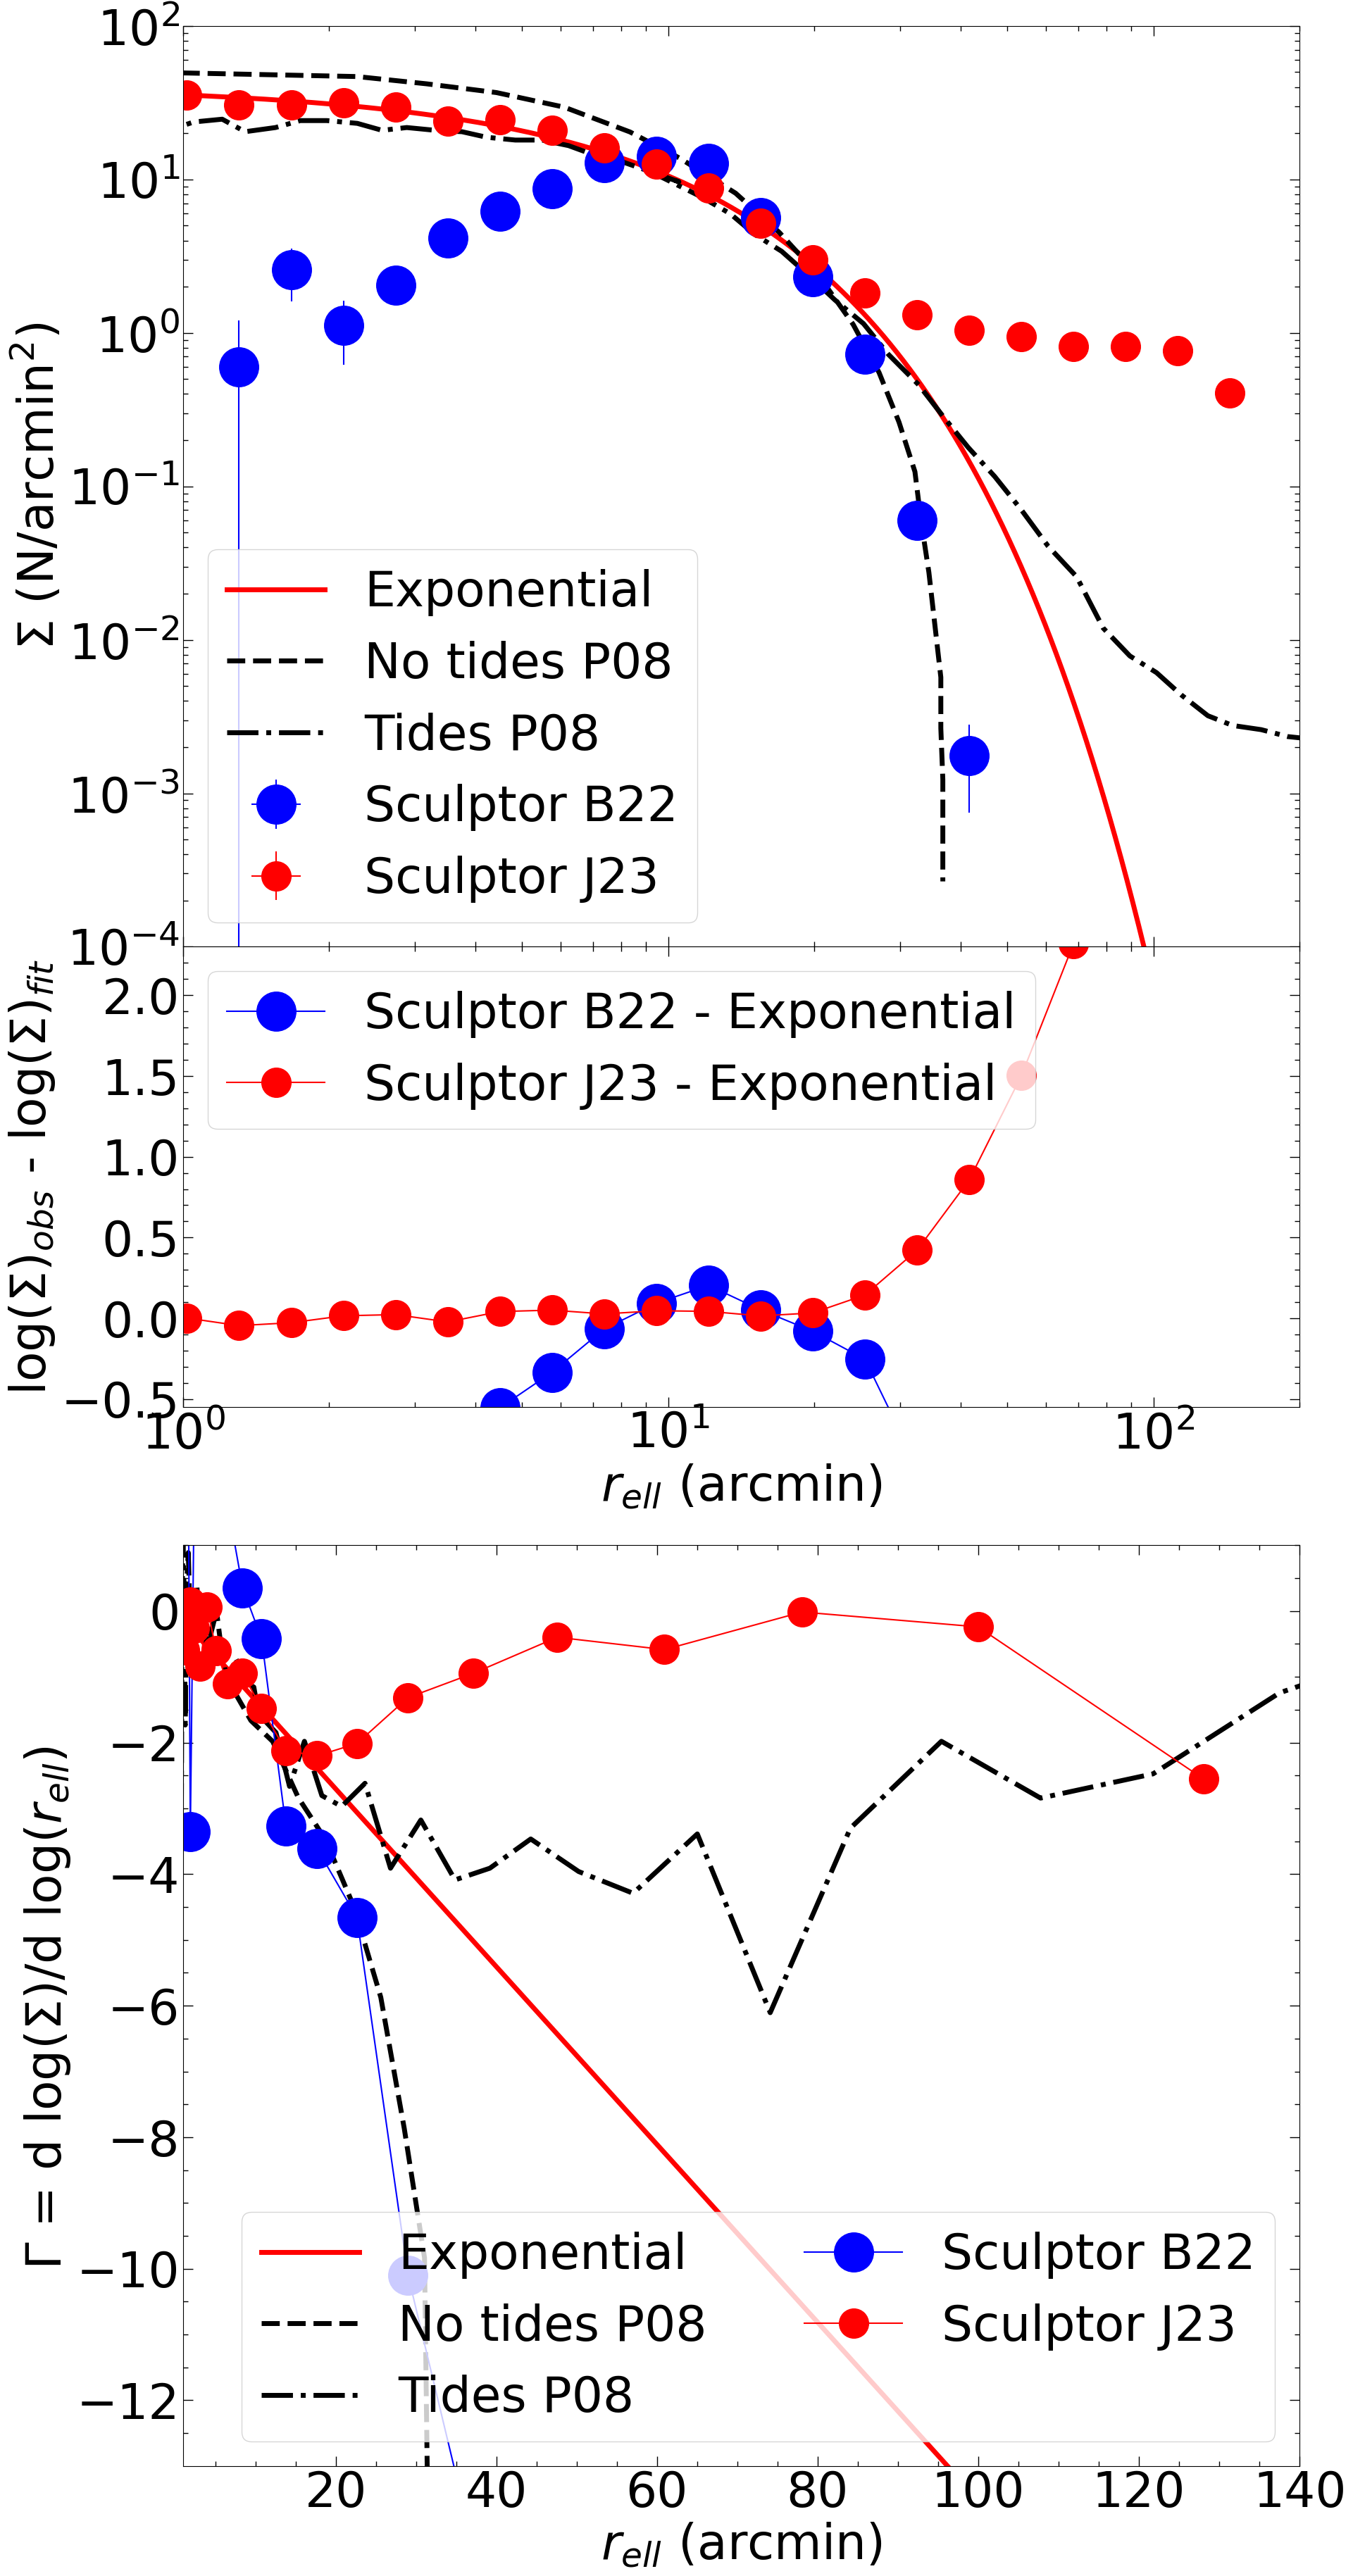

In [19]:
from matplotlib import gridspec

'''
import pandas as pd
Sname = 'Sample0_'
#fcat =Sname+'candidates.csv'
fndens = Sname+'density_y22.csv'
dprof = pd.read_csv(fndens)
x_for_y22,gamma_for_y22=gamma_m(dprof['xr']*60, dprof['counts']/dprof['area']/3600)
'''


fs1=50
fig1 = plt.figure(figsize=(45,45))
gs  = gridspec.GridSpec(ncols=3, nrows=5, width_ratios=[1. , 0.2 ,1.],height_ratios=[1. , 0. ,0.5 , 0.15, 1 ])


ax1 = fig1.add_subplot(gs[0,0])


ax1.plot(x_model*12.33, y_model, color='r', linewidth=5,label='Exponential') #inner exponential

mul=50
mul2=150
#*1.5
ax1.plot(por2*1.5,poy2*mul, color='black', marker='',markersize=25,linestyle='dashed' , linewidth=5,label='No tides P08')
ax1.plot(por*1.5,poy*mul, color='black', marker='',markersize=25,linestyle='dashdot' , linewidth=5,label='Tides P08')

#ax1.plot(bin_alan*12.33,surf_alan_interp, color='red', marker='o',markersize=25,fillstyle='none',linestyle='' ,label='Sculptor MV20')
#ax1.plot(x_bin_alan*12.33, surf_dens_alan, color='red', marker='o',markersize=40,fillstyle='none',linestyle='' ,label='Sculptor MV20')


ax1.errorbar(x_bin*12.33, surf_dens, yerr=surf_dens_err,xerr=dx_bin ,color='blue', marker='.',markersize=80,linestyle='',label='Sculptor B22')
ax1.errorbar(x_bin_j*12.33, surf_dens_j, yerr=surf_dens_err_j,xerr=dx_bin ,color='red', marker='.',markersize=60,linestyle='',label='Sculptor J23')

ax1.legend(fontsize=fs1,loc="lower left")
ax1.set_yscale('log', nonpositive='clip')
ax1.set_xscale('log', nonpositive='clip')
#plt.xlim(0,10.5) #if in r_h
ax1.set_xlim(1,200) #if in arcmin
ax1.set_ylim(0.0001,100)
plt.xticks(fontsize=fs1) 
plt.yticks(fontsize=fs1)

#plt.xlabel( '$r_{ell}$ ($r_h$)',fontsize=fs1)
#plt.xlabel( '$r_{ell}$ (arcmin)',fontsize=fs1)
plt.ylabel('$\Sigma$ (N/arcmin$^2$)',fontsize=fs1)
ax1.minorticks_on()
ax1.set_xticklabels([]) 
#ax1.set_xticks(ticks=[1, 10 ,100])
plt.tick_params( axis='both', which='major', length=10,width=1, direction='in', top=True, bottom=True,right=True, left=True)
plt.tick_params( axis='both', which='minor', length=5,width=1, direction='in', top=True, bottom=True,right=True, left=True)







ax3 = fig1.add_subplot(gs[2,0])

ax3.plot(x_bin*12.33, np.log10(surf_dens)-np.log10(inner_exp_int) , color='blue', marker='o',markersize=40,linestyle='-', label='Sculptor B22 - Exponential') #inner exponential
ax3.plot(x_bin_j*12.33, np.log10(surf_dens_j)-np.log10(inner_exp_int_j) , color='red', marker='o',markersize=30,linestyle='-', label='Sculptor J23 - Exponential') #inner exponential

#plt.yscale('log', nonpositive='clip')
plt.xscale('log', nonpositive='clip')
plt.xlim(1,200) #if in arcmin
plt.ylim(-0.55,2.3)
plt.xticks(fontsize=fs1) 
plt.yticks(fontsize=fs1)
plt.xlabel( '$r_{ell}$ (arcmin)',fontsize=fs1)
plt.ylabel('log($\Sigma$)$_{obs}$ - log($\Sigma$)$_{fit}$',fontsize=fs1)
plt.minorticks_on()
plt.tick_params( axis='both', which='major', length=10,width=1, direction='in', top=True, bottom=True,right=True)
plt.tick_params( axis='both', which='minor', length=5,width=1, direction='in', top=True, bottom=True,right=True)
plt.legend(fontsize=fs1,loc="upper left")
plt.subplots_adjust(wspace=0, hspace=0)




ax5 = fig1.add_subplot(gs[4,0])


#lin_grid=np.linspace(0.5, 10.5, 20) #linear grid in r_h
#gamma_obs_lin=np.interp(lin_grid, x_obs,gamma_obs, left=None, right=None, period=None)

#lin_grid_al=np.linspace(0.5, 6.5, 14) #linear grid in r_h
#gamma_al_lin=np.interp(lin_grid_al, x_al,gamma_al, left=None, right=None, period=None)

ax5.plot(x_inexp*12.33,gamma_inexp, color='r', linewidth=5, label='Exponential') #inner exponential
#*1.5
ax5.plot(x_pen2*1.5,gamma_pen2, color='black', marker='',markersize=5,linestyle='dashed', linewidth=5,label='No tides P08') 
ax5.plot(x_pen*1.5,gamma_pen, color='black', marker='',markersize=5,linestyle='dashdot', linewidth=5,label='Tides P08')


ax5.plot(x_obs[x_obs*12.33<1]*12.33,gamma_obs[x_obs*12.33<1], color='b', marker='o',markersize=1,linestyle='-') 
ax5.plot(x_obs[x_obs*12.33>1]*12.33,gamma_obs[x_obs*12.33>1], color='b', marker='o',markersize=40,linestyle='-',label='Sculptor B22') 

ax5.plot(x_obs_j[x_obs_j*12.33<1]*12.33,gamma_obs_j[x_obs_j*12.33<1], color='r', marker='o',markersize=1,linestyle='-') 
ax5.plot(x_obs_j[x_obs_j*12.33>1]*12.33,gamma_obs_j[x_obs_j*12.33>1], color='r', marker='o',markersize=30,linestyle='-',label='Sculptor J23') 


#plt.xlim(0,10.5) #if in r_h
plt.xlim(1,140) #if in arcmin
plt.ylim(-13,1)
plt.xticks(fontsize=fs1) 
plt.yticks(fontsize=fs1)

#plt.xlabel( '$r_{ell}$ ($r_h$)',fontsize=fs1)
plt.xlabel( '$r_{ell}$ (arcmin)',fontsize=fs1)
plt.ylabel('$\Gamma$ = d log($\Sigma$)/d log($r_{ell}$) ',fontsize=fs1)
plt.legend(ncol=2,fontsize=fs1,loc="lower right")

plt.minorticks_on()
plt.tick_params( axis='both', which='major', length=10,width=1, direction='in', top=True, bottom=True,right=True)
plt.tick_params( axis='both', which='minor', length=5,width=1, direction='in', top=True, bottom=True,right=True)
#print(dlogy)
#print(surf_dens)


plt.tick_params( axis='both', which='major', length=10,width=1, direction='in', top=True, bottom=True,right=True)
plt.tick_params( axis='both', which='minor', length=5,width=1, direction='in', top=True, bottom=True,right=True)



ax1.set_xticks(ticks=[1, 10 ,100])

plt.savefig('surface.pdf',bbox_inches='tight')
#print(dlogy)
#print(surf_dens)


#remove the models P08 for Fornax


In [13]:
disp_v=9.2 #kms
tperi=0.41 #Gyr
coe=0.55

break_r= 0.55*tperi* 31556952.0*1e9*disp_v*3.2407792896664e-17 #in kpc

print(break_r,'kpc')


dist_umi=86.0 #kpc
rh_umi=12.33 #arcmin

break_arc= np.rad2deg( np.arctan(break_r/dist_umi) )*60.0
print(break_arc,'arcmin')
print(break_arc/12.33,'rh')

2.1216750906309345 kpc
84.79421474372823 arcmin
6.877065267131243 rh
